In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [3]:
# Load dataset
df = pd.read_csv(r'C:\Users\kaviya\Downloads\GOOG.csv')  # Replace with your dataset path
df.head()

# Select features (e.g., 'Open', 'High', 'Low', 'Close', 'Volume')
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].values

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, seq_length=SEQ_LENGTH)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (3665, 30, 5), Validation set: (458, 30, 5), Test set: (459, 30, 5)


In [4]:
def build_lstm(hidden_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(hidden_units, activation='tanh', return_sequences=False, input_shape=(SEQ_LENGTH, X_train.shape[2])),
        Dropout(dropout_rate),
        Dense(1)  # Predicting a single value (next day's 'Close')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Build the model
model = build_lstm()
model.summary()


C:\Users\kaviya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 4.3324e-04 - val_loss: 1.0599e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 5.0382e-04 - val_loss: 1.4527e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4.8690e-04 - val_loss: 1.1480e-04
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4.2251e-04 - val_loss: 1.8369e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.0665e-04 - val_loss: 1.1605e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.0984e-04 - val_loss: 1.5217e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9337e-04 - val_loss: 1.1765e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.0936e-04 - val_loss: 1.1305e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.0614e-04 - val_loss: 1.2233e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4.6023e-04 - val_loss: 1.0303e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/

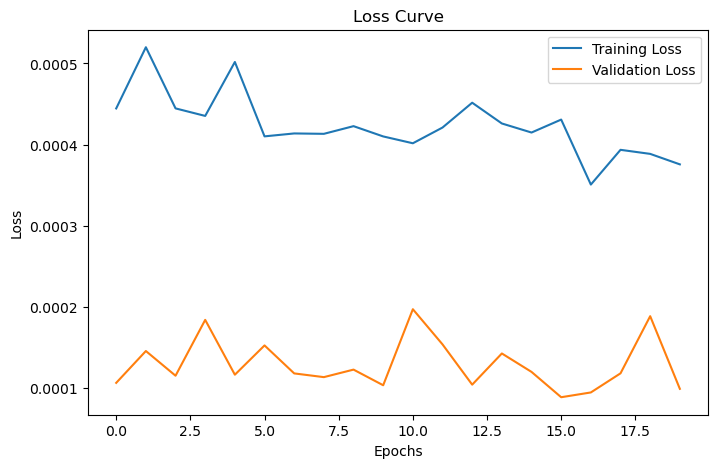

In [14]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Hyperparameter grid
hidden_units_list = [50, 100]
dropout_rates = [0.2, 0.3]
learning_rates = [0.001, 0.0005]

best_model = None
best_val_loss = float('inf')
results = []

for hidden_units in hidden_units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            print(f"Testing: hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            model = build_lstm(hidden_units, dropout_rate, learning_rate)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=30,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=0
            )
            val_loss = min(history.history['val_loss'])
            results.append((hidden_units, dropout_rate, learning_rate, val_loss))
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model

# Best hyperparameters
best_params = sorted(results, key=lambda x: x[3])[0]
print(f"Best Parameters: hidden_units={best_params[0]}, dropout_rate={best_params[1]}, learning_rate={best_params[2]}")


Testing: hidden_units=50, dropout_rate=0.2, learning_rate=0.001
Testing: hidden_units=50, dropout_rate=0.2, learning_rate=0.0005
Testing: hidden_units=50, dropout_rate=0.3, learning_rate=0.001
Testing: hidden_units=50, dropout_rate=0.3, learning_rate=0.0005
Testing: hidden_units=100, dropout_rate=0.2, learning_rate=0.001
Testing: hidden_units=100, dropout_rate=0.2, learning_rate=0.0005
Testing: hidden_units=100, dropout_rate=0.3, learning_rate=0.001
Testing: hidden_units=100, dropout_rate=0.3, learning_rate=0.0005
Best Parameters: hidden_units=100, dropout_rate=0.3, learning_rate=0.001


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0192e-04
Test Loss: 9.943266195477918e-05
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


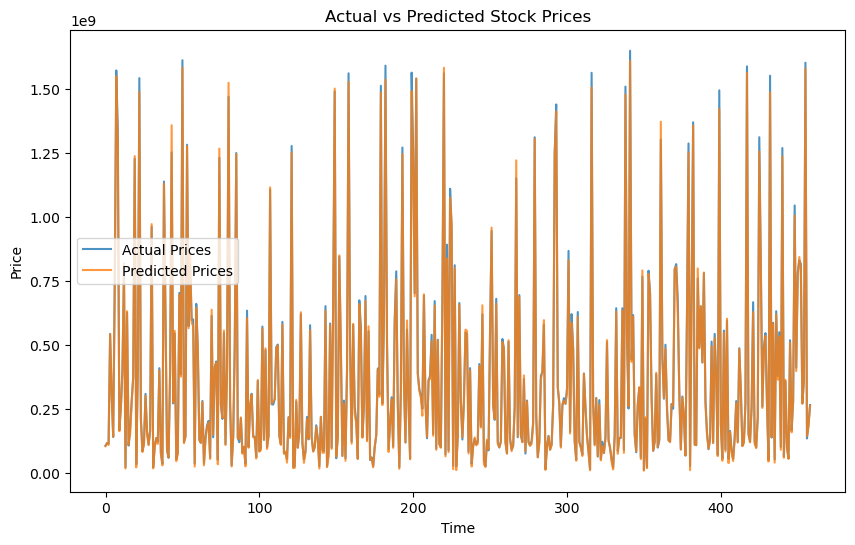

In [13]:
# Evaluate on the test set
test_loss = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Predict
y_pred = best_model.predict(X_test)

# Rescale predictions and ground truth to original scale
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], data.shape[1]-1)), y_pred.reshape(-1, 1)], axis=1))[:, -1]

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Prices', alpha=0.8)
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


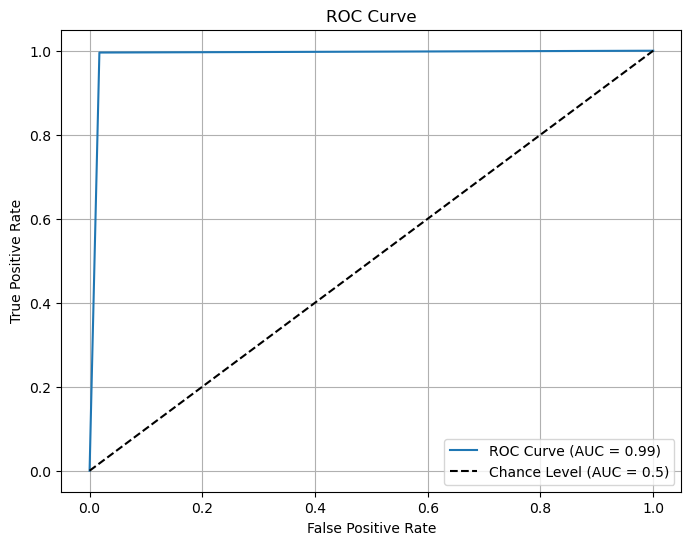

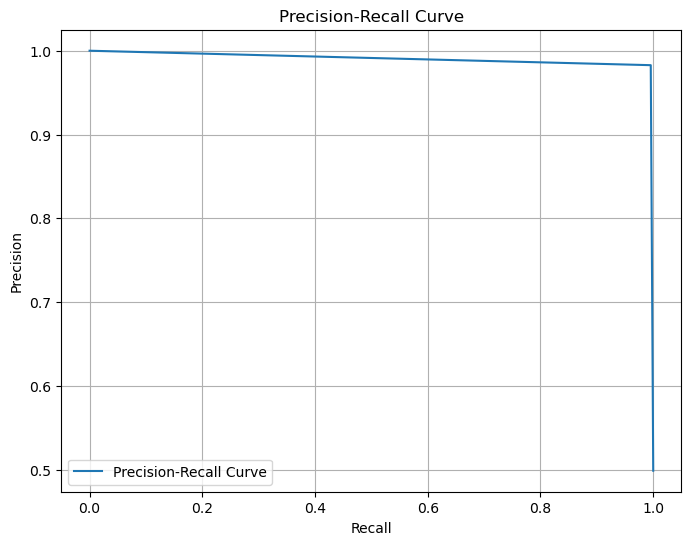

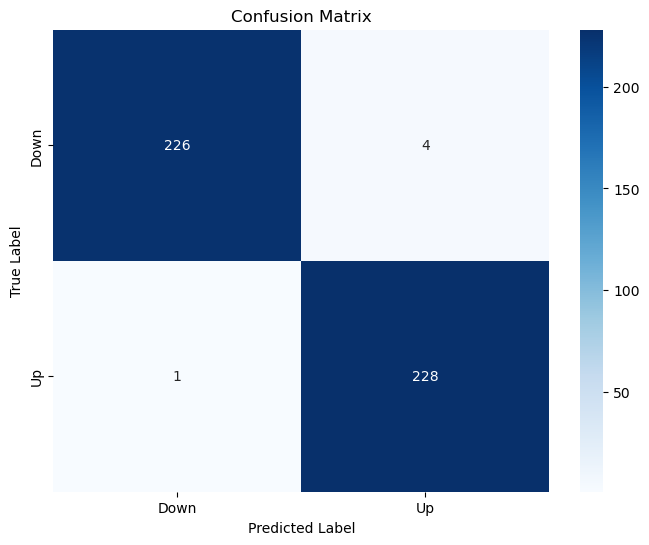

              precision    recall  f1-score   support

        Down       1.00      0.98      0.99       230
          Up       0.98      1.00      0.99       229

    accuracy                           0.99       459
   macro avg       0.99      0.99      0.99       459
weighted avg       0.99      0.99      0.99       459



In [15]:
# Generate Binary Labels for ROC
y_test_binary = (np.diff(y_test_rescaled, prepend=y_test_rescaled[0]) > 0).astype(int)
y_pred_binary = (np.diff(y_pred_rescaled, prepend=y_pred_rescaled[0]) > 0).astype(int)

# Calculate Metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_binary)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Classification Report
report = classification_report(y_test_binary, y_pred_binary, target_names=['Down', 'Up'])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print Classification Report
print(report)
